In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import multiprocessing

cores_available = multiprocessing.cpu_count()

In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/foursquare-location-matching/sample_submission.csv
/kaggle/input/foursquare-location-matching/pairs.csv
/kaggle/input/foursquare-location-matching/train.csv
/kaggle/input/foursquare-location-matching/test.csv


Split data with knn on lat and long


In [6]:
# pd.read_csv('kaggle/input/foursquare-location-matching/pairs.csv')

In [7]:
# pd.read_csv('kaggle/input/foursquare-location-matching/test.csv')

#  Submission Example:

In [8]:
pd.read_csv('/kaggle/input/foursquare-location-matching/sample_submission.csv')

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


# Read training set:

In [9]:
df = pd.read_csv('/kaggle/input/foursquare-location-matching/train.csv')

In [10]:
df.head(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [11]:
df.groupby('country').agg({'id':'count'}).sort_values(by='id',ascending=False).rename(columns={'id':'countries_count'}).describe()

,countries_count
count,221.000000
mean,5152.945701
std,21442.432855
min,1.000000
25%,13.000000
50%,113.000000
75%,1429.000000
max,245284.000000


In [12]:
df.groupby('point_of_interest').agg({'id':'count'}).sort_values(by='id',ascending=False).rename(columns={'id':'POI_count'})

,POI_count
point_of_interest,
P_fb339198a31db3,332
P_3a3fbd26e16269,199
P_f70a0977377171,166
P_9290e406eb58ac,145
P_fbe61733fcdebe,132
...,...
P_6c88990990db38,1
P_6c884940447aa7,1
P_6c8847f66224e2,1


In [13]:
df.loc[df['point_of_interest']=='P_fb339198a31db3']

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
10820,E_02761e40f68230,Sukarno Hatta airport,-7.329110,108.213608,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
14686,E_0351377fc6b71d,Bandara Soekarno Hatta,-6.143365,106.729291,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
19520,E_046132a06d8bc5,Bandar Djakarta,-6.117818,106.855710,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
21192,E_04c39deab3aba2,"Bandara Soekarnao Hatta...^^,",-6.234635,106.874453,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
21433,E_04d15c990bfd9e,Bandara Soekarno Hatta,1.541611,98.915245,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120868,E_fbfa341173cef3,Soekarno Hatta International Airport,-7.952919,112.628568,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
1133655,E_fed28e5ada5e81,Otw Soetta,-6.261004,106.767409,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
1137194,E_ffa093e04175aa,Kawasan Soetta,-6.109597,106.653188,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
1138441,E_ffe8c72a51f9c6,Bandara Soekarno Hatta,-6.130148,106.657134,NaN,Jakarta,NaN,NaN,ID,NaN,NaN,Buildings,P_fb339198a31db3


In [14]:
df.loc[df['point_of_interest']=='P_3a3fbd26e16269']

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
5864,E_01561528896296,Deleted Venue (SEO),53.977069,38.186727,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
12290,E_02c9ac4b08b798,Deleted Venue (SEO),64.224874,41.657732,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
26065,E_05d696f881a2ab,Deleted Venue (SEO),59.412537,24.666926,NaN,NaN,NaN,NaN,EE,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
47312,E_0a958576584978,Deleted Venue (SEO),54.315757,48.399682,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
47616,E_0aa699e0d786d8,Deleted Venue (SEO),58.057184,38.768620,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118135,E_fb5cc62697c52f,Deleted Venue (SEO),55.850651,37.520563,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
1131160,E_fe46470b6468e1,Deleted Venue (SEO),50.642078,36.572086,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
1133143,E_feb4399ea9b283,Deleted Venue (SEO),58.377787,26.730695,NaN,NaN,NaN,NaN,EE,NaN,NaN,Mattress Stores,P_3a3fbd26e16269
1135479,E_ff3e99adafc6c0,Deleted Venue (SEO),57.636972,39.862831,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269


In [15]:
import pyproj
transformer = pyproj.Transformer.from_crs(
        {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
        {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
        )
#x, y, z = transformer.transform( lon,lat,  0,radians=False)

In [16]:
%%time
geocentr_cartesian = df[[ 'latitude', 'longitude']].apply(lambda x: transformer.transform( x.longitude, x.latitude, 0, radians=False), axis=1).to_numpy()

CPU times: user 1min 6s, sys: 496 ms, total: 1min 7s
Wall time: 1min 7s


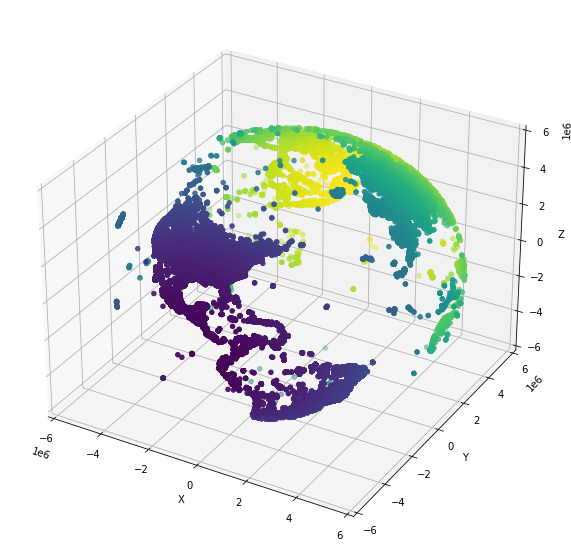

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(
    list(map(lambda x: x[0], geocentr_cartesian)),
    list(map(lambda x: x[1], geocentr_cartesian)),
    list(map(lambda x: x[2], geocentr_cartesian)), 
    c=list(map(lambda x: x[1], geocentr_cartesian))
)
# Set limits of the 3D display
ax.set_xlim3d([-6000000, 6000000])
ax.set_ylim3d([-6000000, 6000000])
ax.set_zlim3d([-6000000, 6000000])

# Set labels at the 3d box/frame
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [18]:
from scipy import spatial

In [19]:
%%time

tree = spatial.KDTree(geocentr_cartesian.tolist())
loc_data = tree.query(geocentr_cartesian.tolist(),10, workers=max(cores_available-1, 1))    
distances, indices = loc_data

CPU times: user 10.9 s, sys: 87.7 ms, total: 11 s
Wall time: 5.86 s


In [20]:
indices

array([[      0,  704744,  280465, ...,   75629,  324453,  318934],
       [      1,  860109, 1101190, ...,  911520, 1043520,   24873],
       [      2,  812192,  119820, ...,  509371,  176102, 1032718],
       ...,
       [1113074,  412437, 1138809, ...,  293310,   69015,  284087],
       [1138810,  135823,  989208, ...,  210362,  806167,   20470],
       [1138811,  670304,  119981, ..., 1023047,  414736,  471379]])

In [21]:
from sklearn.neighbors import KNeighborsRegressor
